# Genexpert data exploration and analysis

*Initialize...*

In [2]:
from IPython.display import display, HTML

import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib as mlp
import matplotlib.pyplot as plt
import geopandas as gp

import os

os.chdir("../../../core")
import GT_helper_functions as hf
import GT_load_data as data

base_dir = "../../Outcome Measurement Data/"

FileNotFoundError: [WinError 2] El sistema no puede encontrar el archivo especificado: '../../../core'

In [18]:
%matplotlib inline
plt.style.use('ggplot')
mlp.rcParams["figure.facecolor"] = "white"
mlp.rcParams["figure.dpi"] = 100
mlp.rcParams["figure.figsize"] = [10,7]

In [17]:
priordepts2014 = [1, 5, 12, 10, 9, 11, 18, 19 ]
priordepts2018 = [10, 11, 12, 14, 9, 13, 16, 18, 1, 5, 17]
labs = [17, 16,18,19,1,13,12,9,11,10,5]

## Read cohort data

In [4]:
datadf = pd.read_csv(\
"../../Outcome Measurement Data/TUBERCULOSIS/GTM - Tx cohort data 2012-2016.csv", index_col = 0)
#deptos = gp.read_file("../../../../Covariates and Other Data/GIS/GT-IGN-cartografia_basica-Departamentos.geojson")

In [5]:
temp = datadf[#(datadf.row_name_.isin(["FALLECIDOS"])) & 
              (datadf.col_name.isin(["TOTAL"])) & 
       (datadf.table.isin(["Nuevos Pulmonares BK+", "Nuevos Pulmonares BK-", "Nuevos Pediatricos", 
                          "Nuevos Extrapulmonares", "Nuevos TB/VIH", "Retratamiento"
                          ])) &
       (datadf.deptocode!=0)].\
    groupby(["year", "row_name"]).value.sum().unstack(1)
temp["total"] = temp.sum(axis="columns")
temp

row_name,ABANDONO/PERDIDA_SEGM,CURADOS,FALLECIDOS,FRACASO_TERAPEUTICO,TRANSFERIDOS,TRATAMIENTOS COMPLETOS,total
year,,,,,,,
2012,194.0,1926.0,227.0,49.0,30.0,1221.0,3647.0
2013,252.0,1859.0,244.0,48.0,23.0,1046.0,3472.0
2014,257.0,1829.0,198.0,50.0,3.0,925.0,3262.0
2015,258.0,1911.0,211.0,46.0,8.0,1015.0,3449.0
2016,215.0,1899.0,196.0,42.0,12.0,922.0,3286.0


In [6]:
temp = datadf[(datadf.col_name.isin(["TOTAL"])) & 
       (datadf.table.isin(["Nuevos Pulmonares Genexpert"
                          ])) &
       (datadf.deptocode!=0)].\
    groupby(["year", "row_name"]).value.sum().unstack(1)

In [7]:
temp["total"] = temp.sum(axis="columns")
temp

row_name,ABANDONO/PERDIDA_SEGM,CURADOS,FALLECIDOS,FRACASO_TERAPEUTICO,TRANSFERIDOS,TRATAMIENTOS COMPLETOS,total
year,,,,,,,
2016,15.0,25.0,11.0,1.0,0.0,137.0,189.0


## Read notifications data 

In [8]:
tbnots = pd.read_csv(base_dir + "TUBERCULOSIS/GTM - TB notifications 2012-2017.csv", 
                     encoding="latin-1", index_col = 0, low_memory = False)

In [9]:
tbnots.head()

,NOMBRES,DIRECCION,MUNICIPIO,DEPARTAMENTO,SERVICIODESALUD,SEXO,EDAD,RANGOEDAD,PESOLBS,PESOKG,...,CULTIVO_RESULTADO,CULTIVO_FECHA,FECHA,OBSERVACION,RESISTENCIA,FECHARESULTADOPDS,NotificationDate,YearMonth_,DEPTO_CORRECTED,COD_DEPT
1,NaN,NaN,TUCURU,ALTA VERAPAZ,"CS, TUCURU",m,17.0,015 - 019,123,55.90909091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALTA VERAPAZ,16
2,NaN,NaN,TUCURU,ALTA VERAPAZ,"CS, TUCURU",m,49.0,045 - 049,125,56.81818182,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALTA VERAPAZ,16
3,NaN,NaN,TUCURU,ALTA VERAPAZ,"CS, TUCURU",m,25.0,025 - 029,97,44.09090909,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALTA VERAPAZ,16
4,NaN,NaN,TUCURU,ALTA VERAPAZ,"CS, TUCURU",f,46.0,045 - 049,88,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALTA VERAPAZ,16
5,NaN,NaN,TELEMAN,ALTA VERAPAZ,"CS, TELEMAN",m,47.0,045 - 049,ND,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALTA VERAPAZ,16


# MDR

## Genexpert

In [9]:
#tbnots.METODODX.value_counts(dropna=False)
tbnots["Genexpert"] =  tbnots.METODODX.map(lambda x: "xpert" in str.lower(x) if not pd.isna(x) else False)

In [10]:
tbnots["Year"] = np.floor(tbnots.YearMonth/100)

In [11]:
tbnots.groupby(["Genexpert", "Year"]).apply(len)

Genexpert  Year  
False      2012.0    4246
           2013.0    4685
           2014.0    4557
           2015.0    3847
           2016.0    3730
           2017.0    4045
True       2015.0     432
           2016.0     373
           2017.0     488
dtype: int64

In [12]:
gxpertMapData = tbnots[(tbnots.CONDICIONINGRESO == "nuevo") & 
                       (tbnots.Year>2014)].groupby(["Year", "Genexpert", "COD_DEPT"])\
                            .apply(len).unstack(1, fill_value=0)

In [13]:
gxpertMapData = gxpertMapData.reset_index().rename(columns={ "COD_DEPT": "deptocode"}).assign(Total = lambda x: x[False] + x[True])\
                        .assign(Percentage = lambda x: x[True]/x["Total"]*100)

In [14]:
mlp.rcParams['figure.figsize'] = [8, 8]

def deptosMap2Way(x, y = None, mapdata = None, xlabel="", ylabel="", xmax = None, grayZeroX = True):
    if xmax is None:
        xmax = temp[x].max()
    mapdata = mapdata.assign(deptocode=lambda x: (x.deptocode * 100).astype(int).astype(str)\
                                                 .map(lambda y: y if y != "100" else "101"))
    temp = data.deptosGTshp.merge(mapdata[["deptocode", x]], 
                         left_on="CODIGO", right_on = "deptocode", how="left" )
    
    nans = temp[temp[x].isna() | (temp[x]==0) | (np.isinf(temp[x]))]
    if len(nans) > 0:
        nans.plot(color="grey", ax= ax) 

    goodvals = temp[(temp[x].isna()==False)]
    if len(goodvals) > 0:
        goodvals.plot(x, ax=ax, vmin = 0, vmax = xmax,
                                    legend=False, edgecolor="black", cmap = "Blues")
    l1 = ax.get_legend()
    for i, depto in data.deptosGTshp.iterrows():
        plt.text(depto.geometry.centroid.x, (depto.geometry.bounds[3]+1.5*depto.geometry.centroid.y)/2.5, 
                 hf.abbreviate(depto.DEPARTAMEN), color="black",
                 horizontalalignment='center', alpha=0.8, fontsize=9)

    if y is not None:
        temp2 = data.deptosGTshp.merge(mapdata[["deptocode", y]][mapdata[y]>0], 
                             left_on="CODIGO", right_on = "deptocode", how="left" )\
            .assign(_x = lambda row: row.geometry.centroid.x)\
            .assign(_y = lambda row: row.geometry.centroid.y)
        plt.scatter(temp2._x, temp2._y, temp2[y], c = "red", alpha=0.8, linewidths=1.5, edgecolors="black", 
                label = ylabel + " ( " + str(temp2[y].min()) + " to " + str(temp2[y].max()) + " )")

    cmap = plt.get_cmap('Blues')
    norm = mlp.colors.Normalize(vmin=0,vmax=xmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, shrink = 0.5, ticks=np.linspace(0, xmax, 10))
    cbar.set_ticklabels([int(np.round(x)) for x in np.linspace(0, xmax, 10)])
    cbar.set_label(xlabel)
    plt.legend(bbox_to_anchor=(1,0))
    plt.axis("off")

data.deptosGTshp["deptocode"] = (data.deptosGTshp.CODIGO.astype(int)/100).astype(int)
    
def additionalMarkers(ax):
    j = 0
    for i, depto in data.deptosGTshp[data.deptosGTshp.deptocode.isin(priordepts2014)].iterrows():
        plt.scatter(depto.geometry.centroid.x-0.06,(depto.geometry.bounds[1]+1.5*depto.geometry.centroid.y)/2.5,
                    60, linewidths= 2, edgecolor = "black", alpha=0.7,
                    label = "Department prioritized in 2014" if j == 0 else None,
                    marker='o', color='#fF9900')
        j += 1
    j = 0
    for i, depto in data.deptosGTshp[data.deptosGTshp.deptocode.isin(priordepts2018)].iterrows():
        plt.scatter(depto.geometry.centroid.x+0.06, (depto.geometry.bounds[1]+1.5*depto.geometry.centroid.y)/2.5, 
                    60, linewidths= 2, edgecolor = "black", alpha=0.7,
                    label = "Department prioritized in 2018" if j == 0 else None,
                    marker='o', color='#50bF75')
        j += 1
    j = 0
    for i, depto in data.deptosGTshp[data.deptosGTshp.deptocode.isin(labs)].iterrows():
        plt.scatter(depto.geometry.centroid.x+0.15, (depto.geometry.bounds[3]+1.5*depto.geometry.centroid.y)/2.5-0.05,
                    50, linewidths= 2, edgecolor = "black", alpha=1,
                    label = "Department with Genexpert labs" if j == 0 else None,
                    marker='*', color='black')
        j += 1


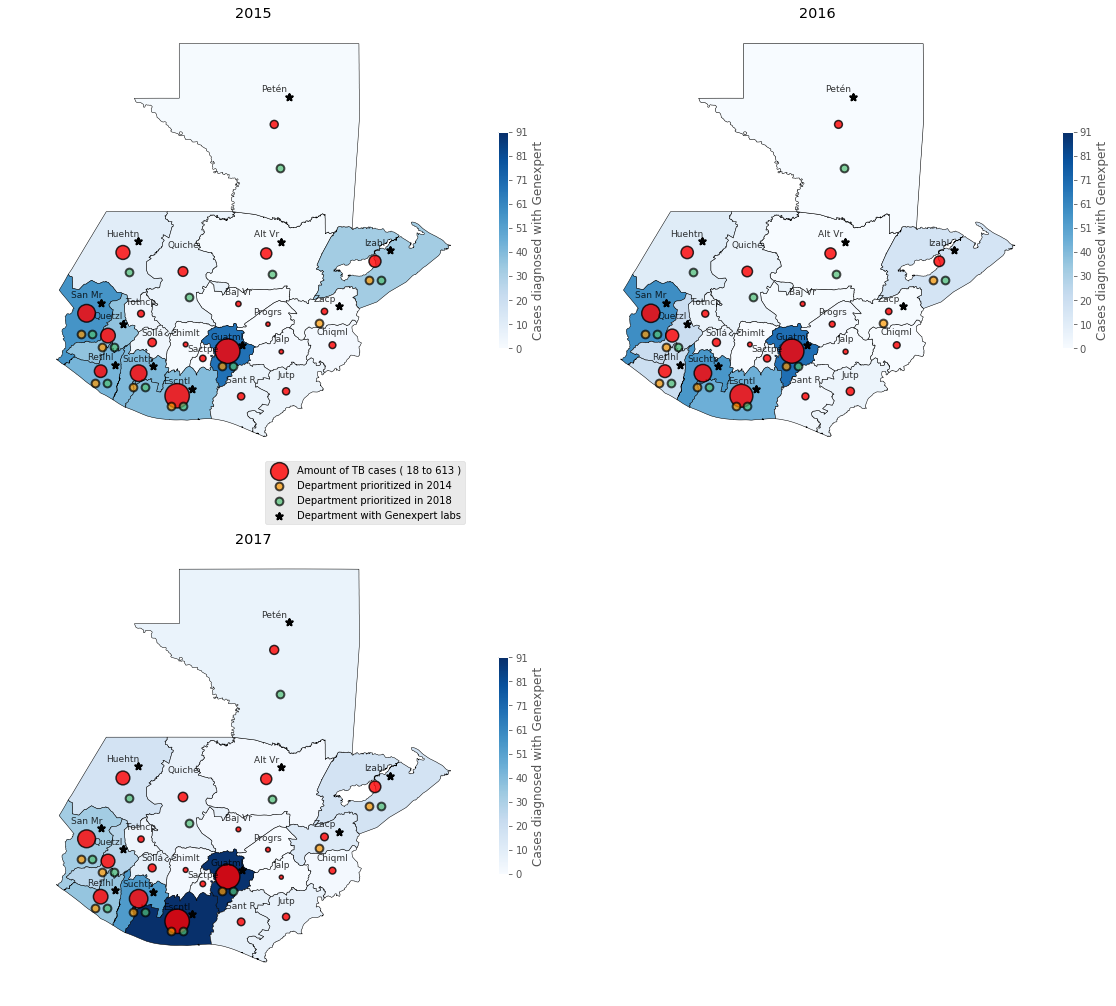

In [15]:

mlp.rcParams["figure.figsize"] = (16, 14)
xmax = gxpertMapData[True].max()
ax = plt.subplot(2,2,1)
deptosMap2Way(True, "Total", gxpertMapData[gxpertMapData.Year == 2015], "Cases diagnosed with Genexpert", "Amount of TB cases",
             xmax = xmax)
additionalMarkers(ax)
plt.legend(bbox_to_anchor=(1,0))
ax.set_title("2015")
ax = plt.subplot(2,2,2)
deptosMap2Way(True, "Total", gxpertMapData[gxpertMapData.Year == 2016], "Cases diagnosed with Genexpert", "Amount of TB cases",
             xmax = xmax)
additionalMarkers(ax)
plt.legend().remove()
ax.set_title("2016")
ax = plt.subplot(2,2,3)
deptosMap2Way(True, "Total", gxpertMapData[gxpertMapData.Year == 2017], "Cases diagnosed with Genexpert", "Amount of TB cases",
             xmax = xmax)
additionalMarkers(ax)
plt.legend().remove()
ax.set_title("2017")
plt.tight_layout(pad=0.8)

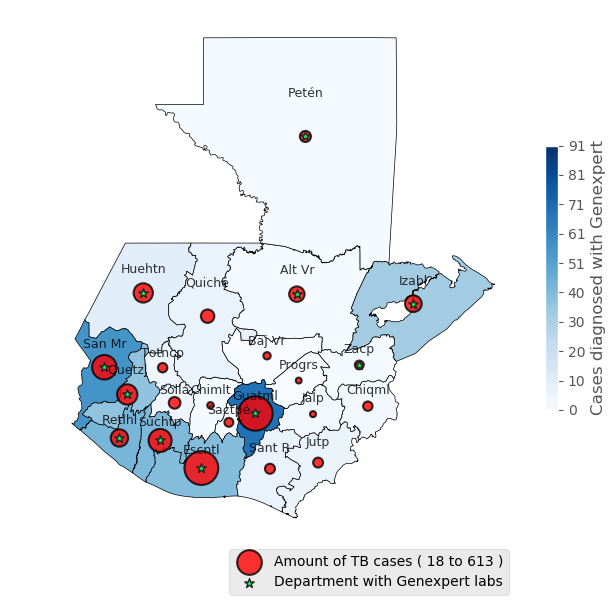

In [54]:
mlp.rcParams["figure.figsize"] = (7.5, 7)
xmax = gxpertMapData[True].max()
ax = plt.subplot(1,1,1)
deptosMap2Way(True, "Total", gxpertMapData[gxpertMapData.Year == 2015], "Cases diagnosed with Genexpert", "Amount of TB cases",
             xmax = xmax)

j = 0
for i, depto in data.deptosGTshp[data.deptosGTshp.deptocode.isin(labs)].iterrows():
    plt.scatter(depto.geometry.centroid.x, (0*depto.geometry.bounds[3]+1*depto.geometry.centroid.y)/1,
                50, linewidths= 1, edgecolor = "#222222", alpha=1,
                label = "Department with Genexpert labs" if j == 0 else None,
                marker='*', color='#15FD59')
    j += 1
plt.legend(bbox_to_anchor=(1,0))


In [51]:
#set.symmetric_difference(set([17, 16,18,19,1,13,12,9,11,10,5]), set([1, 1, 1, 1, 18, 10, 13, 11, 5, 12, 9, 9, 16, 17, 19, 1]))

Text(0,0.5,'Cases count')

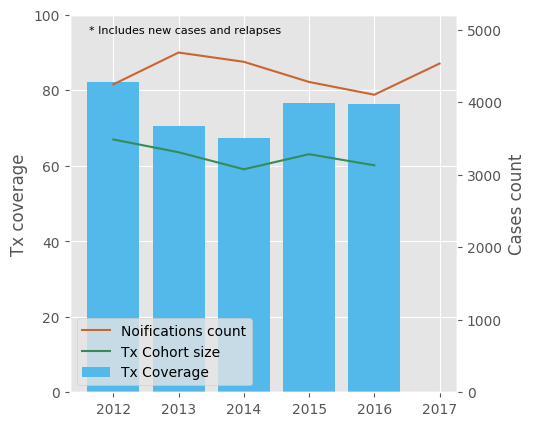

In [105]:
mlp.rcParams["figure.figsize"] = (5, 5)
# Genexpert no es confiable en notificaciones. No concuerda con datos de laboratorios (totales > 1000, en notifs es ~ 400)
# tbnots[(tbnots.CONDICIONINGRESO == "nuevo") ].groupby(["Year", "Genexpert"]).apply(len).unstack(1).fillna(0)
d = pd.concat([
    tbnots.groupby(["Year"]).apply(len).fillna(0)\
        .rename("notifications"),
    datadf[(datadf.col_name.isin(["TOTAL"])) & 
       (datadf.table.isin(["Nuevos Pulmonares BK+", "Nuevos Pulmonares BK-", 
                           "Nuevos Pediatricos", 
                           "Nuevos Extrapulmonares", "Nuevos TB/VIH", "Retratamientos"
                          ])) &
       (datadf.deptocode!=0)].\
    groupby(["year"]).value.sum().rename("cohortes")], 1)
d["coverage"] = 100*d.cohortes/d.notifications
ax = plt.axes()
plt.bar(d.index, d.coverage, color="#53B8EA", label="Tx Coverage")
plt.text(0.05,0.95, "* Includes new cases and relapses", transform=ax.transAxes, fontsize=8)
plt.ylim(0,100)
shrink = 0.9
plt.plot(d.index, shrink*100*d.notifications/d.notifications.max(), 
         label = "Noifications count",
        color= "#C96533")
plt.plot(d.index, shrink*100*d.cohortes/d.notifications.max(), label = "Tx Cohort size",
        color= "#348C5D")
plt.legend(loc="lower left")
plt.ylabel("Tx coverage")
ax2 = plt.twinx()
ax2.set_ylim(0,d.notifications.max()/shrink)
ax2.grid(False)
ax2.set_ylabel("Cases count")


In [94]:
#tbnots[(tbnots.CONDICIONINGRESO == "nuevo") ].groupby(["Year", "Genexpert", "SEXO", "EDAD"])\
#    .Genexpert.count().unstack(1).unstack(1).fillna(0).to_excel("temp.xlsx")
#tbnots.columns #FECHAINICIOTX.value_counts(dropna=False)
tbnots.CONDICIONINGRESO.value_counts()

nuevo                        18874
recaida                        870
abandono/r                     218
fracaso                         80
perdida en el seguimiento       46
abandono recuperado              4
42790                            3
especial                         1
42740                            1
42788                            1
abandono recuperada              1
Name: CONDICIONINGRESO, dtype: int64

In [10]:
# Lets start with the missing basic data for pediatric and extrapulmonares cases: 
temp = datadf[(datadf.col_name.isin(["TOTAL"])) & 
       (datadf.table.isin(["Nuevos Pulmonares BK+", "Nuevos Pulmonares BK-", "Nuevos Pediatricos", 
                          "Nuevos Extrapulmonares", "Nuevos TB/VIH", "Retratamiento"])) &
       (datadf.deptocode.isin([0]) )].\
    groupby(["table", "year"]).value.sum()
temp = temp.unstack(0).fillna(0)
temp["total"] = temp.sum(axis=1)
temp = \
    (np.round(temp.divide(temp["total"] , axis="rows")*100, decimals=0))
temp
#temp = temp.stack().reset_index()[lambda x: x["row_name"] != "total"]
#temp.columns = ["Depto", "TB Category", "Outflow condition", "Percentage"]

#temp

table,Nuevos Extrapulmonares,Nuevos Pediatricos,Nuevos Pulmonares BK+,Nuevos Pulmonares BK-,Nuevos TB/VIH,Retratamiento,total
year,,,,,,,
2012,8.0,11.0,59.0,11.0,7.0,4.0,100.0
2013,8.0,8.0,62.0,11.0,7.0,5.0,100.0
2014,9.0,8.0,61.0,10.0,6.0,6.0,100.0
2015,9.0,0.0,62.0,19.0,5.0,5.0,100.0
2016,8.0,6.0,69.0,7.0,5.0,5.0,100.0


In [52]:
#mdr2014 = 

In [97]:
xp2016 = pd.read_excel("../../Outcome Measurement Data/TUBERCULOSIS/Xpert 2016 2017 2018.xlsx", 0, skiprows=3, index_col = 0)
xp2017 = pd.read_excel("../../Outcome Measurement Data/TUBERCULOSIS/Xpert 2016 2017 2018.xlsx", 1, skiprows=4, index_col = 0)
xp2018 = pd.read_excel("../../Outcome Measurement Data/TUBERCULOSIS/Xpert 2016 2017 2018.xlsx", 2, skiprows=4, index_col = 0)

In [98]:
xp2016.columns = [1, 12, 9, 10, 18, 5, 11, 1, 1, 1, "X1", "X2"]

In [99]:
xp2017.columns = [1, 12, 9, 10, 18, 5, 11, 1, 1, 1, 19, "Total"]

In [100]:
xp2018.columns = [1, 1, 1, 1, 18, 10, 13, 11, 5, 12, 9, 9, 16, 17, 19, 1, "Total"]

In [107]:
xp2017

,1,12,9,10,18,5,11,1,1,1,19,Total
Resultado,,,,,,,,,,,,
MTB-,638.000000,582,864.000000,344.0,216.000000,489.000000,462.000000,1020.000000,575.000000,224.000000,225.000000,5639.0
MTB+ RIF-,211.000000,71,234.000000,49.0,30.000000,233.000000,79.000000,105.000000,309.000000,10.000000,52.000000,1383.0
MTB+ RIF?,8.000000,1,2.000000,0.0,0.000000,1.000000,1.000000,4.000000,1.000000,0.000000,0.000000,18.0
MTB+ RIF+,16.000000,8,25.000000,7.0,1.000000,15.000000,8.000000,3.000000,15.000000,2.000000,4.000000,104.0
Total de positivos,235.000000,80,261.000000,56.0,31.000000,249.000000,88.000000,112.000000,325.000000,12.000000,56.000000,1505.0
NaN,6.808511,10,9.578544,12.5,3.225806,6.024096,9.090909,2.678571,4.615385,16.666667,7.142857,NaN
Invalido,10.000000,6,1.000000,0.0,1.000000,4.000000,0.000000,4.000000,7.000000,0.000000,3.000000,36.0
Errores,21.000000,8,20.000000,11.0,4.000000,1.000000,12.000000,27.000000,10.000000,11.000000,2.000000,127.0
No result,5.000000,3,2.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.0
